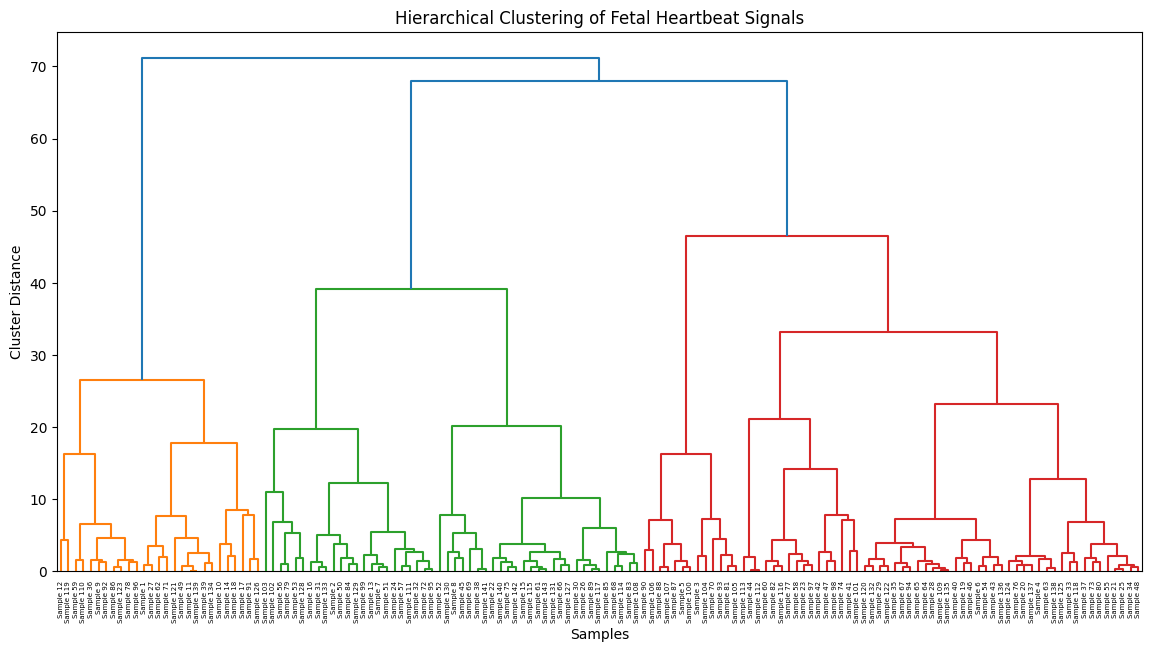

Healthy Heartbeats (BPM, Sample): [(np.float64(137.36089030206676), '000.mat'), (np.float64(112.61730969760168), '007.mat'), (np.float64(139.05579399141632), '008.mat')]
Anomalous Heartbeats (BPM, Sample): [(np.float64(136.4005412719892), '001.mat'), (np.float64(137.87234042553192), '006.mat'), (np.float64(161.27999999999997), '007.mat')]


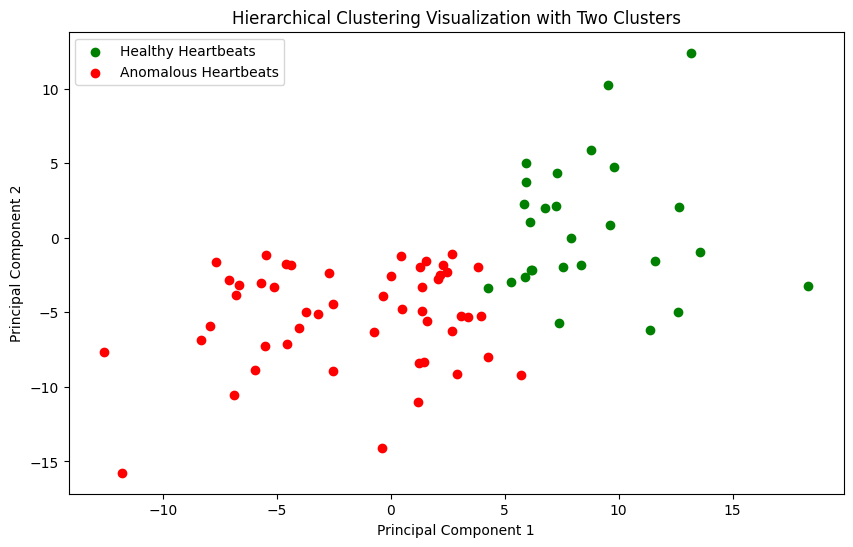

Plotting 3 healthy heartbeats...


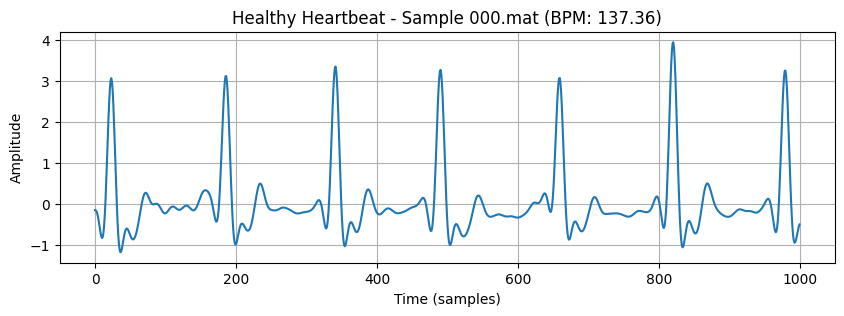

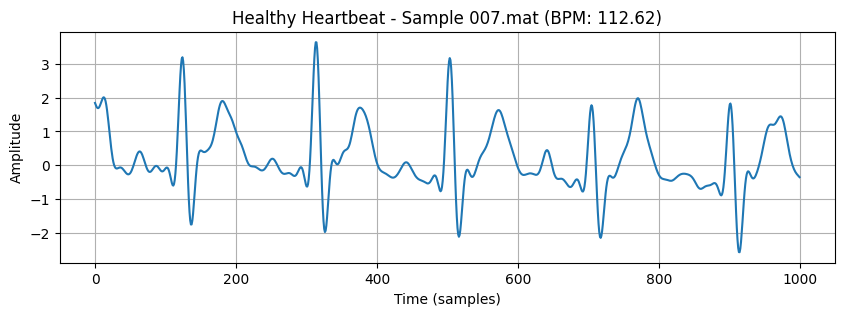

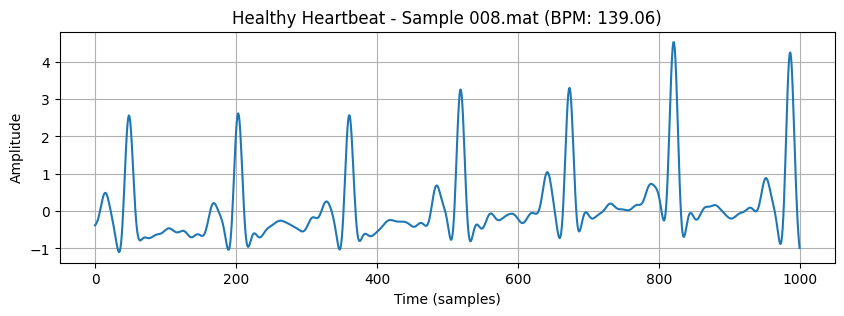

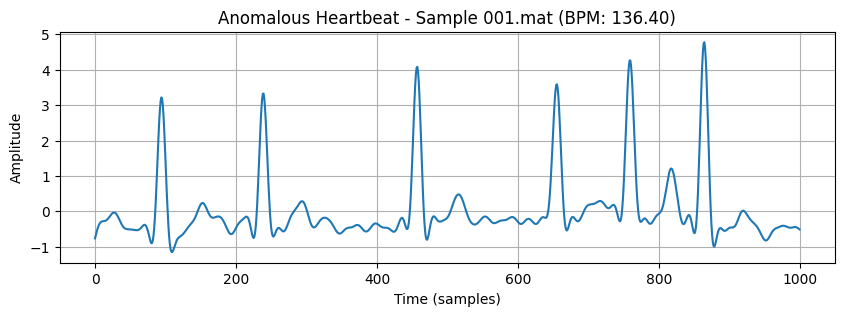

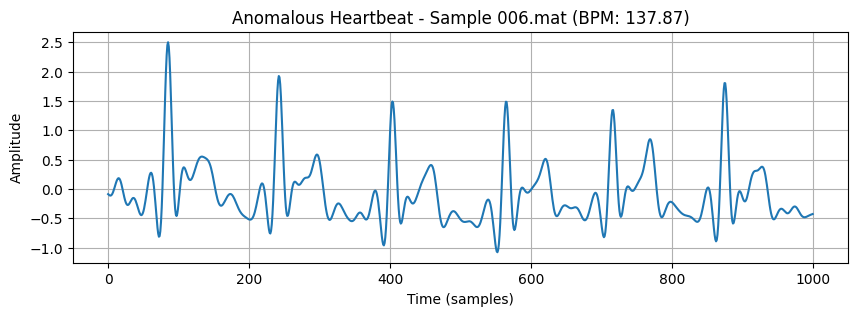

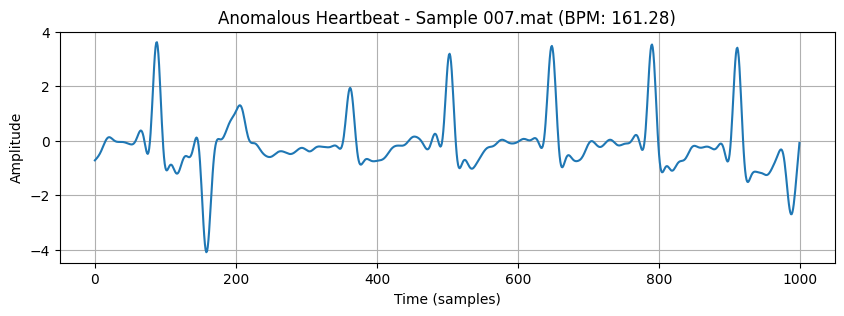

In [51]:
import numpy as np
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt, find_peaks
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import heartpy as hp
import warnings

warnings.simplefilter('ignore')

# Function to perform ICA
def performICA(data, heartbeats_only=True):
    heartbeats = []
    ica = FastICA(n_components=4)
    data = data.T
    components = ica.fit_transform(data)
    for i in range(4):
        component = components[:, i]
        if np.min(component) < -2: component *= -1
        if np.max(component) > 4: heartbeats.append(component)
        if not heartbeats_only and np.max(component) <= 5: heartbeats.append(5)
    return heartbeats

# Function to filter signals with a low-pass filter
def butter_lowpass_filter(data, cutoff=20, fs=360, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Function to check and correct signal rotation
def check_rotation(component, sr):
    distance = sr / 10
    _, properties = find_peaks(component, distance=distance, height=0.1 * np.max(component))
    _, inverted_properties = find_peaks(-component, distance=distance, height=0.1 * np.max(-component))

    avg_peak_height = np.mean(properties['peak_heights'])
    avg_inv_peak_height = np.mean(inverted_properties['peak_heights'])

    if avg_inv_peak_height > avg_peak_height:
        component = -component

    return component

# Function to calculate heart rate
def calculate_heartrate(component, sr):
    component = check_rotation(component, sr)
    working_data, measures = hp.process(component, sample_rate=sr)
    return component, working_data, measures

# Directory containing all .mat files
data_dir = 'heartbeat_data'
all_heartbeats = []

# Loop through all .mat files in the directory
for filename in sorted(os.listdir(data_dir)):
    if filename.endswith('.mat'):
        file_path = os.path.join(data_dir, filename)
        data = loadmat(file_path)
        data_matrix = np.array(data['val'][0])
        heartbeats = performICA(data_matrix)
        for h in heartbeats:
            all_heartbeats.append((h, filename))

# Process heartbeats and classify them as maternal or fetal
heartbeatsWithBpm = []
fetusBpmMin = 110

for i, heartbeat in enumerate(all_heartbeats):
    try:
        component, working_data, measures = calculate_heartrate(heartbeat[0], 360)
        heartbeatsWithBpm.append((heartbeat[0], heartbeat[1], measures['bpm'], measures['pnn50']))
    except:
        continue

# Separate fetal heartbeats
fetus = [hb for hb in heartbeatsWithBpm if hb[2] >= fetusBpmMin]

# Standardize fetal signals and apply filtering
scaler = StandardScaler()
fetus_signals = [hb[0][:1000] for hb in fetus]
stdFetus = scaler.fit_transform(fetus_signals)
stdFetusFiltered = [butter_lowpass_filter(x) for x in stdFetus]

# Dimensionality reduction with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
clusterData_reduced = pca.fit_transform(stdFetusFiltered)

# Hierarchical clustering
Z = linkage(clusterData_reduced, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 7))
dendrogram(Z, labels=[f'Sample {i+1}' for i in range(len(clusterData_reduced))], leaf_rotation=90)
plt.title('Hierarchical Clustering of Fetal Heartbeat Signals')
plt.xlabel('Samples')
plt.ylabel('Cluster Distance')
plt.show()

# Cluster assignment with two clusters
max_distance = 50  # Adjust this value to ensure two clusters
clusters = fcluster(Z, max_distance, criterion='distance')

# Separate the data points into the two clusters
healthy_cluster_indices = [i for i, c in enumerate(clusters) if c == 1]
anomalous_cluster_indices = [i for i, c in enumerate(clusters) if c == 2]

# Get BPM and samples for clusters
healthy_heartbeats = [(fetus[i][2], fetus[i][1]) for i in healthy_cluster_indices]
anomalous_heartbeats = [(fetus[i][2], fetus[i][1]) for i in anomalous_cluster_indices]

# Select three samples from each cluster
healthy_examples = healthy_heartbeats[:3]
anomalous_examples = anomalous_heartbeats[:3]

# Print examples
print("Healthy Heartbeats (BPM, Sample):", healthy_examples)
print("Anomalous Heartbeats (BPM, Sample):", anomalous_examples)

# Visualize the two clusters
plt.figure(figsize=(10, 6))
plt.scatter(clusterData_reduced[healthy_cluster_indices, 0], clusterData_reduced[healthy_cluster_indices, 1], 
            label='Healthy Heartbeats', color='green')
plt.scatter(clusterData_reduced[anomalous_cluster_indices, 0], clusterData_reduced[anomalous_cluster_indices, 1], 
            label='Anomalous Heartbeats', color='red')
plt.legend()
plt.title('Hierarchical Clustering Visualization with Two Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Plot the first 3 healthy heartbeats
print("Plotting 3 healthy heartbeats...")
for i, (bpm, sample) in enumerate(healthy_examples):
    idx = healthy_cluster_indices[i]  # Get the index of the signal in the dataset
    plt.figure(figsize=(10, 3))
    plt.plot(stdFetusFiltered[idx])
    plt.title(f"Healthy Heartbeat - Sample {sample} (BPM: {bpm:.2f})")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

# Plot the first 3 anomalous heartbeats
for i, (bpm, sample) in enumerate(anomalous_examples):
    idx = anomalous_cluster_indices[i]  # Get the index of the signal in the dataset
    plt.figure(figsize=(10, 3))
    plt.plot(stdFetusFiltered[idx])
    plt.title(f"Anomalous Heartbeat - Sample {sample} (BPM: {bpm:.2f})")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

